# <div style="text-align: center"> Final Project </div>
<div style="text-align: center"> EE367
<br>
<br>
<div style="text-align: center"> Stanford University Winter 2021 </div>
<br>
<div style="text-align: center"> Erick Blankenberg, Scott Blankenberg </div>

---
_Note: Run all of these cells in order if using for the first time. Make sure that your kernel is set to the environment created with `stereoEnviron.yml`._

---
Imports relevant assets to run all of the algorithms.

### 1). DeepPruner
Most of the code used can be found at [this repository](https://github.com/uber-research/DeepPruner) made publicaly available by Uber Research as a companion to their paper "DeepPruner: Learning Efficient Stereo Matching via Differentiable PatchMatch" available [here](https://arxiv.org/abs/1909.05845).
<br>
<br>
The code below downloads the pre-trained weights corresponding to `DeepPruner-best (KITTI)` available [here](https://drive.google.com/file/d/1mSendpKq0vdQMr5XVp5zAHm37dwEgcun/view) where the script is expecting to find them.
<br>
<br>
___Notes:___
* Only the deeppruner folder from the repository is included, `submission.py` and other code to run the network is replaced with `wrapper_deepPruner.py`.
* Changes to original code to run without CUDA:
    * In `models/config.py` changed "training" to "evaluation" on line 31.
    * Throughout many of the `*.py` files in the `models` folder changed `device = *.get_device()` to `device = torch.device("cpu")` and any references to device number to 0.

In [ ]:
from Utils.google_drive_downloader import GoogleDriveDownloader as gdd
import os, ssl, urllib, shutil, zipfile
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Retrieve trained model
if not os.path.isfile("Algorithms/DeepPruner/DeepPruner-best-kitti.tar"):
    print("Starting trained model download...")
    gdd.download_file_from_google_drive(file_id='1mSendpKq0vdQMr5XVp5zAHm37dwEgcun', dest_path='./Algorithms/DeepPruner/DeepPruner-best-kitti.tar')
    print("Finshed downloading trained model.")
else:
    print("Trained model already in directory.")

### 2). PSMNet
Most of the code used can be found at [this repository](https://github.com/JiaRenChang/PSMNet) made publicaly available by Jia-Ren Chang and Yong-Sheng as a companion to their paper "Pyramid Stereo Matching Network" available [here](https://arxiv.org/abs/1803.08669).
<br>
<br>
The code below downloads the pre-trained weights for the `KITTI 2015` dataset available [here](https://drive.google.com/file/d/1pHWjmhKMG4ffCrpcsp_MTXMJXhgl3kF9/view) where the script is expecting to find them.
<br>
<br>
___Notes:___
* Removed extraneous files, `submission.py` and other code to run the network is replaced with `wrapper_PSMNet.py`.
* Changes to original code to run without CUDA:
    * Throughout all of the `*.py` files in the `models` folder removed the function call `*.cuda()` so that the model would run CPU only.

In [2]:
from Utils.google_drive_downloader import GoogleDriveDownloader as gdd
import os, ssl, urllib, shutil, zipfile
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context
    
# Retrieve trained model
if not os.path.isfile("Algorithms/PSMNet/pretrained_model_KITTI2015.tar"):
    print("Starting trained model download...")
    gdd.download_file_from_google_drive(file_id='1pHWjmhKMG4ffCrpcsp_MTXMJXhgl3kF9', dest_path='./Algorithms/PSMNet/pretrained_model_KITTI2015.tar')
    print("Finshed downloading trained model.")
else:
    print("Trained model already in directory.")

Starting trained model download...
Finshed downloading trained model.


### 3). StereoBM:
This is the standard go-to stereo matching algorithm implemented in OpenCV based off of the block matching algorithm. No preperation is necessary beyond installing the library.

### 4). Test images:
Run each of the cells to download the relevant dataset. If you would like to add your own do the following:
<br>
1) Create a new folder under `Data` with the desired name of the dataset.
<br>
2) Add camera calibration information if necessary as `calib.txt` (see existing text files for reference). Add stereo images `Left.*` and `Right.*`, and add the left ground truth disparity `disparityGTLeft.*`.
<br>
3) Re-run the `Scan For Existing` cell to populate the testImages list.
<br>
<br>
4) If you have time, add a new cell to the notebook.
<br>
<br>
___Note:___
<br>
<br>
Some algorithms freeze when run on very large images. Thus all images are scaled so that they fit within `imageMaxDims` defined below when the code is run. Disparity values are likewise scaled. Thus you can include high-resolution images in the comparison data-set but note that they will be resized before evaluation.

#### Scan for Existing Images

In [12]:
import os

# Feel free to add more files, if you run this twice existing files will not be re-loaded so just append and load-away!

skimageTypeList = ["pfm"] # file types that PIL cannot handle
imageMaxDims = [432, 381] # [540, 960] rows, columns. Some algorithms crash when running on high resolution data. Images and disparities are resized so that no dimension exceeds these values

# List of all sources, each one corresponds to a directory in "Data" which contains Left.jpg, Right.jpg, calib.txt, gTruth.jpg
# Actually importing these is in each of the next cells, if the subfolder does not exist then the image is skipped during evaluation

testImages = list()
root = os.getcwd() + "/Data"
if not os.path.isdir(root):
    print("No Data folder found, creating empty folder...")
    os.mkdir(root)
else:
    for files in os.listdir(root):    
        if os.path.isdir(os.path.join(root,files)):
            testImages.append(files)
    print("Existing Images: ")
    print(testImages)


Existing Images: 
['MBD_2001Scenes_tsukuba', 'MBD_2001Scenes_map', 'MBD_2001Scenes_bull', 'MBD_2001Scenes_poster', 'MBD_2001Scenes_barn2', 'MBD_2001Scenes_venus', 'MBD_2001Scenes_barn1', 'MBD_2001Scenes_sawtooth']


#### Middlebury Stereo Evaluation 2014

<br>

___Note:___
<br>
<br>
These are very high resolution images. It took me about 6 minutes to load each one. Feel free to skip this cell. Note that half-resolution images are available as a .zip on the site.

In [1]:
# Middlebury Stereo Evaluation 2014 Images (Full Resolution)

import os, ssl, urllib
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# takes 6 mins per image set, uncomment this for final load mbd32014Images = ["Adirondack-imperfect", "Backpack-imperfect", "Bicycle1-imperfect", "Cable-imperfect", "Classroom1-imperfect", "Couch-imperfect", "Flowers-imperfect", "Jadeplant-imperfect", "Mask-imperfect", "Motorcycle-imperfect", "Piano-imperfect", "Pipes-imperfect", "Playroom-imperfect", "Playtable-imperfect", "Recycle-imperfect", "Shelves-imperfect", "Shelves-imperfect", "Shopvac-imperfect", "Sticks-imperfect", "Storage-imperfect", "Sword1-imperfect", "Sword2-imperfect", "Umbrella-imperfect", "Vintage-imperfect"]
mbd32014Images = ["Adirondack-imperfect", "Backpack-imperfect", "Bicycle1-imperfect", "Cable-imperfect", "Classroom1-imperfect", "Couch-imperfect", "Flowers-imperfect", "Jadeplant-imperfect", "Mask-imperfect", "Motorcycle-imperfect", "Piano-imperfect", "Pipes-imperfect", "Playroom-imperfect", "Playtable-imperfect", "Recycle-imperfect", "Shelves-imperfect", "Shelves-imperfect", "Shopvac-imperfect", "Sticks-imperfect", "Storage-imperfect", "Sword1-imperfect", "Sword2-imperfect", "Umbrella-imperfect", "Vintage-imperfect"]

for currentImageName in mbd32014Images:
    imageFolderName = 'MBD_2014Scenes_%s' % (currentImageName)
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im0.png" % currentImageName, 'Data/%s/Left.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im1.png" % currentImageName, 'Data/%s/Right.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/calib.txt" % currentImageName, 'Data/%s/calib.txt' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp0.pfm" % currentImageName, 'Data/%s/disparityGTLeft.pfm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp1.pfm" % currentImageName, 'Data/%s/disparityGTRight.pfm' % imageFolderName)
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImageName)
    else:
        print("Already Exists: %s" % currentImageName)
        
print("Done Loading!")

KeyboardInterrupt: 

#### Middlebury Stereo Evaluation 2001

In [9]:
import os, ssl, urllib
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# takes 6 mins per image set, uncomment this for final load mbd32014Images = ["Adirondack-imperfect", "Backpack-imperfect", "Bicycle1-imperfect", "Cable-imperfect", "Classroom1-imperfect", "Couch-imperfect", "Flowers-imperfect", "Jadeplant-imperfect", "Mask-imperfect", "Motorcycle-imperfect", "Piano-imperfect", "Pipes-imperfect", "Playroom-imperfect", "Playtable-imperfect", "Recycle-imperfect", "Shelves-imperfect", "Shelves-imperfect", "Shopvac-imperfect", "Sticks-imperfect", "Storage-imperfect", "Sword1-imperfect", "Sword2-imperfect", "Umbrella-imperfect", "Vintage-imperfect"]
mbd2001Images = [["barn1",    ["im2.ppm", "im6.ppm"], ["disp2.pgm", "disp6.pgm"]], 
                 ["barn2",    ["im2.ppm", "im6.ppm"], ["disp2.pgm", "disp6.pgm"]], 
                 ["bull",     ["im2.ppm", "im6.ppm"], ["disp2.pgm", "disp6.pgm"]], 
                 ["map",      ["im0.pgm", "im1.pgm"], ["disp0.pgm", "disp1.pgm"]], 
                 ["poster",   ["im2.ppm", "im6.ppm"], ["disp2.pgm", "disp6.pgm"]],
                 ["sawtooth", ["im2.ppm", "im6.ppm"], ["disp2.pgm", "disp6.pgm"]],
                 ["tsukuba",  ["scene1.row3.col3.ppm", "scene1.row3.col1.ppm"], ["truedisp.row3.col3.pgm", None]],
                 ["venus",    ["im2.ppm", "im6.ppm"], ["disp2.pgm", "disp6.pgm"]]
                ]

for currentImage in mbd2001Images:
    imageFolderName = 'MBD_2001Scenes_%s' % (currentImage[0])
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        
        # > Left Image
        leftName  = currentImage[1][0]
        leftNameExtension = leftName.split(".")[-1]
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/%s" % (currentImage[0], leftName), 'Data/%s/Left.%s' % (imageFolderName, leftNameExtension))
        
        # > Right Image
        rightName = currentImage[1][1]
        rightNameExtension = rightName.split(".")[-1]
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/%s" % (currentImage[0], rightName), 'Data/%s/Right.%s' % (imageFolderName, rightNameExtension))
        
        # > Left Ground Truth
        if(currentImage[2][0] is not None):
            leftDispName = currentImage[2][0]
            leftDispNameExtension = leftDispName.split(".")[-1]
            urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/%s" % (currentImage[0], leftDispName), 'Data/%s/disparityGTLeft.%s' % (imageFolderName, leftDispNameExtension))
            # For this dataset they scaled the disparity by a factor of 8x
            trueDisparity = np.asarray(Image.open("Data/%s/disparityGTLeft.%s" % (imageFolderName, leftDispNameExtension))).astype("float") / 8.0
            ((Image.fromarray(trueDisparity)).convert("L")).save("Data/%s/disparityGTLeft.%s" % (imageFolderName, leftDispNameExtension))
        
        # > Right Ground Truth
        if(currentImage[2][1] is not None):
            rightDispName = currentImage[2][1]
            rightDispNameExtension = rightDispName.split(".")[-1]
            urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2001/data/%s/%s" % (currentImage[0], rightDispName), 'Data/%s/disparityGTRight.%s' % (imageFolderName, rightDispNameExtension))
            # For this dataset they scaled the disparity by a factor of 8x
            trueDisparity = np.asarray(Image.open("Data/%s/disparityGTRight.%s" % (imageFolderName, leftDispNameExtension))).astype("float") / 8.0
            ((Image.fromarray(trueDisparity)).convert("L")).save("Data/%s/disparityGTRight.%s" % (imageFolderName, leftDispNameExtension))
        
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImage[0])
    else:
        print("Already Exists: %s" % currentImage[0])
        
print("Done Loading!")

Loaded: barn1
Loaded: barn2
Loaded: bull
Loaded: map
Loaded: poster
Loaded: sawtooth
Loaded: tsukuba
Loaded: venus
Done Loading!


#### Middlebury Stereo Evaluation 2006
<br>

___Note:___

I am using half-resolution images here for speed. There are also high-resolution images available but those take a long time to download and would need to be re-scaled anyway.

In [ ]:
# Middlebury Stereo Evaluation 2006 Half Resolution Images
"""
import os, ssl, urllib
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# takes 6 mins per image set, uncomment this for final load mbd32014Images = ["Adirondack-imperfect", "Backpack-imperfect", "Bicycle1-imperfect", "Cable-imperfect", "Classroom1-imperfect", "Couch-imperfect", "Flowers-imperfect", "Jadeplant-imperfect", "Mask-imperfect", "Motorcycle-imperfect", "Piano-imperfect", "Pipes-imperfect", "Playroom-imperfect", "Playtable-imperfect", "Recycle-imperfect", "Shelves-imperfect", "Shelves-imperfect", "Shopvac-imperfect", "Sticks-imperfect", "Storage-imperfect", "Sword1-imperfect", "Sword2-imperfect", "Umbrella-imperfect", "Vintage-imperfect"]
mbd2006HalfImages = ["", "", "", "", ""]

for currentImageName in mbd32014Images:
    imageFolderName = 'MBD_2014Scenes_%s' % (currentImageName)
    if not os.path.isdir('Data/%s' % imageFolderName):
        os.mkdir('Data/%s' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im0.png" % currentImageName, 'Data/%s/Left.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/im1.png" % currentImageName, 'Data/%s/Right.png' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/calib.txt" % currentImageName, 'Data/%s/calib.txt' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp0.pfm" % currentImageName, 'Data/%s/disparityGTLeft.pfm' % imageFolderName)
        urllib.request.urlretrieve("https://vision.middlebury.edu/stereo/data/scenes2014/datasets/%s/disp1.pfm" % currentImageName, 'Data/%s/disparityGTRight.pfm' % imageFolderName)
        testImages.append(imageFolderName)
        print("Loaded: %s" % currentImageName)
    else:
        print("Already Exists: %s" % currentImageName)

"""

---
Runs each of the algorithms

#### Fuzzy Logic

In [ ]:
# Fuzzy Logic


#### DeepPruner

Number of model parameters: 7390142
Loading model...
Model loaded. Running evaluations...

================ MBD_2001Scenes_tsukuba ================

Disparity for image MBD_2001Scenes_tsukuba alreay exists, skipping.
Loading existing data...


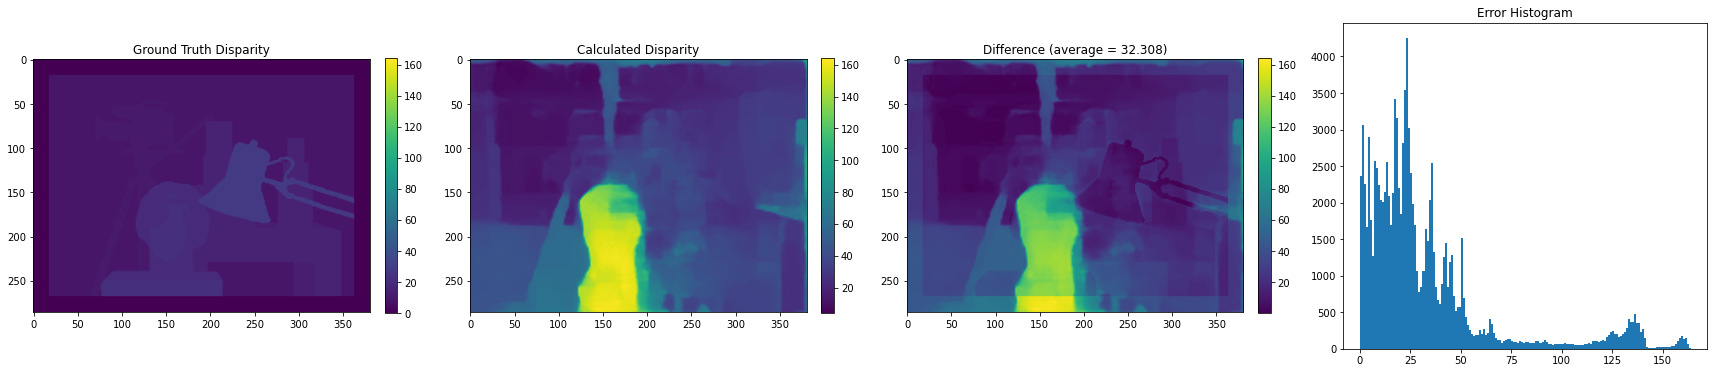



================ MBD_2001Scenes_map ================

Disparity for image MBD_2001Scenes_map alreay exists, skipping.
Loading existing data...


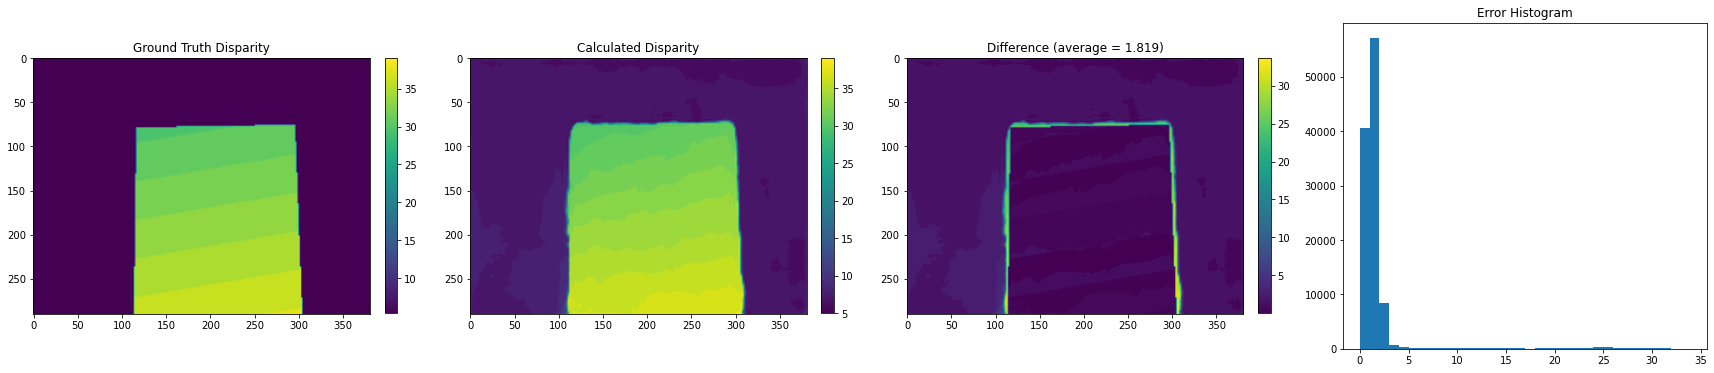



================ MBD_2001Scenes_bull ================

Disparity for image MBD_2001Scenes_bull alreay exists, skipping.
Loading existing data...


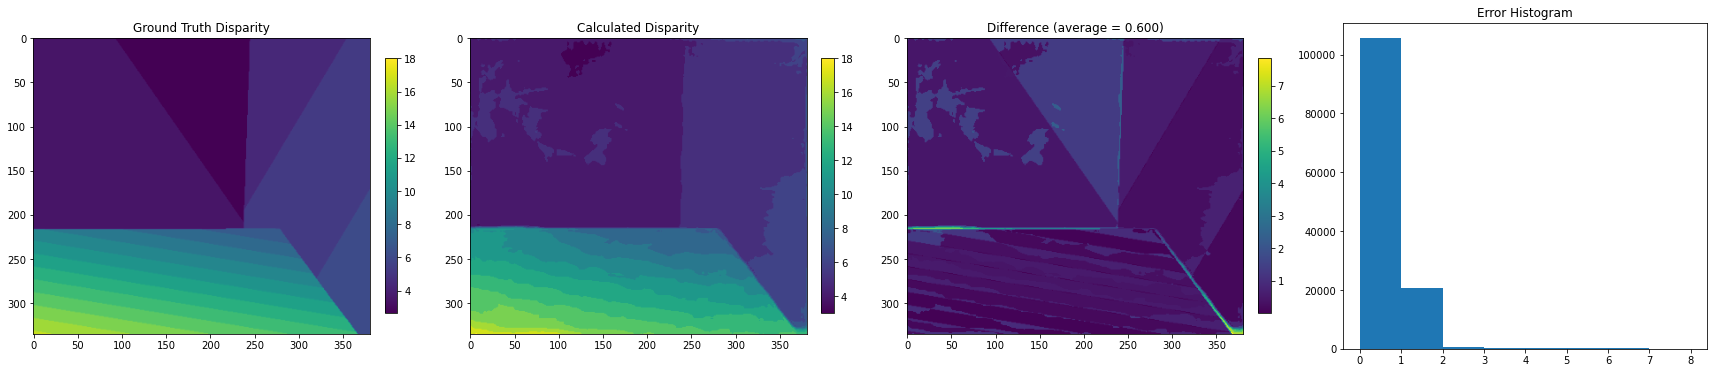



================ MBD_2001Scenes_poster ================

Finished disparity for image MBD_2001Scenes_poster in 50.903 seconds.


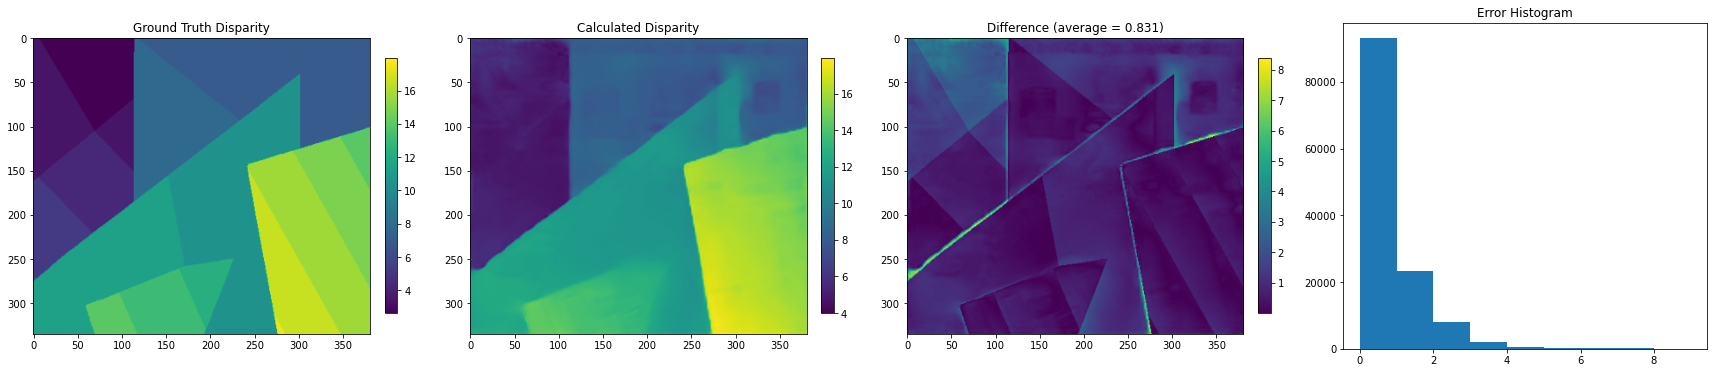



================ MBD_2001Scenes_barn2 ================

Finished disparity for image MBD_2001Scenes_barn2 in 57.073 seconds.


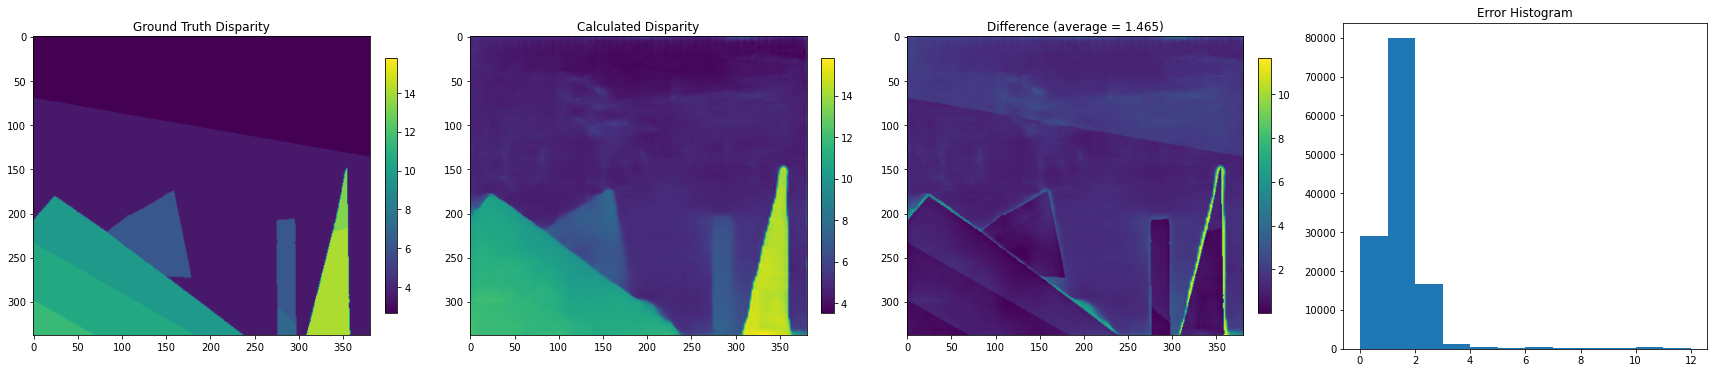



================ MBD_2001Scenes_venus ================

Finished disparity for image MBD_2001Scenes_venus in 53.360 seconds.


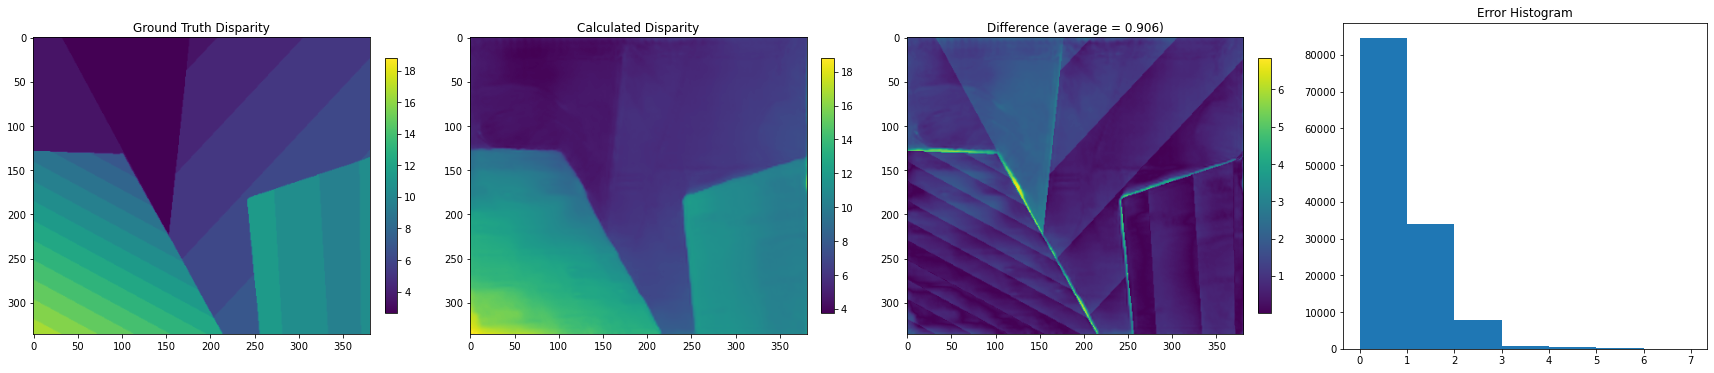



================ MBD_2001Scenes_barn1 ================



In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import torch, skimage.io, numpy as np
import time
from PIL import Image
from Utils import helperfuncs
currentDir = os.getcwd() # Hack to correct deeppruner imports, TODO MODIFY SOURCE FILES SINCE WE ARENT DOWNLOADING FROM SCRATCH ANYMORE
os.chdir(currentDir +  '/Algorithms/DeepPruner')
from dataloader import preprocess
from models.deeppruner import DeepPruner
from models.config import config as config_args
os.chdir(currentDir)
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True
costAggregatorScale = config_args.cost_aggregator_scale
downsampleScale     = costAggregatorScale * 8.0

model = DeepPruner()
model = torch.nn.DataParallel(model)

print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

print("Loading model...")
state_dict = torch.load("./Algorithms/DeepPruner/DeepPruner-best-kitti.tar", map_location=torch.device('cpu'))
model.load_state_dict(state_dict['state_dict'], strict=True)

print("Model loaded. Running evaluations...")

def runtestDeepPruner(imageLeft, imageRight):
    processed = preprocess.get_transform()
    imgL = processed(imageLeft).numpy()
    imgR = processed(imageRight).numpy()

    imgL = np.reshape(imgL, [1, 3, imgL.shape[1], imgL.shape[2]])
    imgR = np.reshape(imgR, [1, 3, imgR.shape[1], imgR.shape[2]])

    w = imgL.shape[3]
    h = imgL.shape[2]
    dw = int(downsampleScale - (w%downsampleScale + (w%downsampleScale==0)*downsampleScale))
    dh = int(downsampleScale - (h%downsampleScale + (h%downsampleScale==0)*downsampleScale))

    top_pad = dh
    left_pad = dw
    imgL = np.lib.pad(imgL, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)
    imgR = np.lib.pad(imgR, ((0, 0), (0, 0), (top_pad, 0), (0, left_pad)), mode='constant', constant_values=0)
    
    startTime = time.time()
    model.eval()
    disparity = None
    with torch.no_grad():
        imgLVar = torch.autograd.Variable(torch.FloatTensor(imgL))
        imgRVar = torch.autograd.Variable(torch.FloatTensor(imgR))

        disparity = model(imgLVar, imgRVar)
    
    runtime = time.time() - startTime
    
    disparity = disparity[0, top_pad:, :-left_pad].data.cpu().numpy()
    
    return disparity, runtime

for currentImage in testImages:
    print("")
    print("================ %s ================" % currentImage)
    print("")
    
    outPath   = helperfuncs.verifyOutPath(currentImage, "DeepPruner")
    disparity = None
    leftPath, rightPath, disparityLeft, disparityRight, cameraCalibration, occlusionMapLeft, occlusionMapRight = helperfuncs.getResourcePaths(currentImage)
    
    targDisparity = disparityLeft
    gtDisparity = None
    #if(disparityLeft is None):
    #    disparityLeft = disparityRight 
    #    oldLeft = leftPath
    #    leftPath = rightPath
    #    rightPath = oldLeft
    #    print("had to flip")
    
    extension = targDisparity.split(".")[-1]
    if(extension in skimageTypeList):
        gtDisparity = skimage.io.imread(targDisparity)
        if(extension == "pfm"):
            gtDisparity = np.flip(gtDisparity, 0)
    else:
        gtDisparity = np.asarray(Image.open(targDisparity)).astype("float")
    
    gtDisparity[gtDisparity == float("inf")] = 0
    adjustedGTDisparity, scale = helperfuncs.standardizedResize1D(gtDisparity, imageMaxDims)
    adjustedGTDisparity = adjustedGTDisparity * scale # Rescale so that pixels match, the other images will rescale appropriately
    
    if(outPath is not None):        

        # Loads the data
        imgL = np.asarray(Image.open(leftPath)).astype("float")
        imgR = np.asarray(Image.open(rightPath)).astype("float")
        if(np.max(imgL) > 1):
            imgL = imgL / 255
            imgR = imgR / 255
        if(len(imgL.shape) <3 or imgL.shape[2] < 3): # We need to convert greyscale to "color"
            imgL = np.stack((imgL, imgL, imgL), 2)
            imgR = np.stack((imgR, imgR, imgR), 2)

        # > Resize 
        imgL, leftScale  = helperfuncs.standardizedResize(imgL, imageMaxDims)
        imgR, rightScale = helperfuncs.standardizedResize(imgR, imageMaxDims)


        # > TODO CAMERA CALIBRATION

        # Does the work
        disparity, runtime  = runtestDeepPruner(imgL, imgR)
        print("Finished disparity for image %s in %0.3f seconds." % (currentImage, runtime))
        ((Image.fromarray(disparity)).convert("L")).save(outPath + "/OutDisparity.ppm")
        np.savetxt(outPath + '/howLong.csv', np.expand_dims(np.asarray(runtime), 0), delimiter=",")
    else:
        print("Loading existing data...")
        disparity = np.asarray(Image.open("Output/%s/DeepPruner/OutDisparity.ppm" % currentImage)).astype("float")
    
    cbarMax = max(np.max(disparity), np.max(adjustedGTDisparity))
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 6))
    
    axs[0].set_title("Ground Truth Disparity")
    im = axs[0].imshow(adjustedGTDisparity, vmax = cbarMax)
    fig.colorbar(im, ax=axs[0], fraction=0.035, pad=0.04)
    
    axs[1].set_title("Calculated Disparity")
    im = axs[1].imshow(disparity, vmax = cbarMax)
    fig.colorbar(im, ax=axs[1], fraction=0.035, pad=0.04)
    diff = np.abs(disparity - adjustedGTDisparity)
    
    axs[2].set_title("Difference (average = %0.3f)" % (np.mean(diff)))
    im = axs[2].imshow(diff)
    fig.colorbar(im, ax=axs[2], fraction=0.035, pad=0.04)
    
    axs[3].set_title("Error Histogram")
    axs[3].hist(np.ndarray.flatten(diff[diff > 0]), bins = np.arange(0, np.max(diff) + 1))
    plt.show()
    print("====================================================")
    print("")

#### PSMNet

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os, random
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import time
from Utils import helperfuncs
from Algorithms.PSMNet.models import *
import matplotlib.pyplot as plt
import skimage.io as io

torch.manual_seed(1)
model = stackhourglass(192) # Default number of disparity levels
model = nn.DataParallel(model, device_ids=[0])

state_dict = None
state_dict = torch.load("Algorithms/PSMNet/pretrained_model_KITTI2015.tar", map_location=torch.device('cpu'))
model.load_state_dict(state_dict['state_dict'])
print('Number of model parameters: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

def runtestPSMNet(imgL,imgR):
        # Prepare image
        normal_mean_var = {'mean': [0.485, 0.456, 0.406],
                            'std': [0.229, 0.224, 0.225]}
        infer_transform = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(**normal_mean_var)])    

        imgL = Image.fromarray(np.uint8(imgL * 255.0))
        imgR = Image.fromarray(np.uint8(imgR * 255.0))
        
        imgL = infer_transform(imgL)
        imgR = infer_transform(imgR) 
       
        # > pad to width and hight to 16 times
        top_pad = 0
        if imgL.shape[1] % 16 != 0:
            times = imgL.shape[1]//16       
            top_pad = (times+1)*16 -imgL.shape[1]

        right_pad = 0
        if imgL.shape[2] % 16 != 0:
            times = imgL.shape[2]//16                       
            right_pad = (times+1)*16-imgL.shape[2]  

        imgL = F.pad(imgL,(0,right_pad, top_pad,0)).unsqueeze(0)
        imgR = F.pad(imgR,(0,right_pad, top_pad,0)).unsqueeze(0)
        
        # Runs evaluation
        startTime = time.time()
        
        model.eval()    

        with torch.no_grad():
            disp = model(imgL,imgR)

        disp = torch.squeeze(disp)
        disparity = disp.data.cpu().numpy()
        
        runTime = time.time() - startTime
        
        # > Remove padding
        if top_pad !=0 and right_pad != 0:
            disparity = disparity[top_pad:,:-right_pad]
        elif top_pad ==0 and right_pad != 0:
            disparity = disparity[:,:-right_pad]
        elif top_pad !=0 and right_pad == 0:
            disparity = disparity[top_pad:,:]
        
        return disparity, runTime

for currentImage in testImages:
    print("")
    print("================ %s ================" % currentImage)
    print("")
    
    outPath   = helperfuncs.verifyOutPath(currentImage, "PSMNet")
    disparity = None
    leftPath, rightPath, disparityLeft, disparityRight, cameraCalibration, occlusionMapLeft, occlusionMapRight = helperfuncs.getResourcePaths(currentImage)
    
    targDisparity = disparityLeft
    gtDisparity = None
    
    extension = targDisparity.split(".")[-1]
    if(extension in skimageTypeList):
        gtDisparity = io.imread(targDisparity)
        if(extension == "pfm"):
            gtDisparity = np.flip(gtDisparity, 0)
    else:
        gtDisparity = np.asarray(Image.open(targDisparity)).astype("float")
    
    gtDisparity[gtDisparity == float("inf")] = 0
    adjustedGTDisparity, scale = helperfuncs.standardizedResize1D(gtDisparity, imageMaxDims)
    adjustedGTDisparity = adjustedGTDisparity * scale # Rescale so that pixels match, the other images will rescale appropriately
    
    if(outPath is not None):        

        # Loads the data
        imgL = np.asarray(Image.open(leftPath)).astype("double")
        imgR = np.asarray(Image.open(rightPath)).astype("double")
        if(np.max(imgL) > 1):
            imgL = imgL / 255.0
            imgR = imgR / 255.0
        if(len(imgL.shape) <3 or imgL.shape[2] < 3): # We need to convert greyscale to "color"
            imgL = np.stack((imgL, imgL, imgL), 2)
            imgR = np.stack((imgR, imgR, imgR), 2)

        # > Resize 
        imgL, leftScale  = helperfuncs.standardizedResize(imgL, imageMaxDims)
        imgR, rightScale = helperfuncs.standardizedResize(imgR, imageMaxDims)


        # > TODO CAMERA CALIBRATION

        # Does the work
        disparity, runtime  = runtestPSMNet(imgL, imgR)
        print("Finished disparity for image %s in %0.3f seconds." % (currentImage, runtime))
        ((Image.fromarray(disparity)).convert("L")).save(outPath + "/OutDisparity.ppm")
        np.savetxt(outPath + '/howLong.csv', np.expand_dims(np.asarray(runtime), 0), delimiter=",")
    else:
        print("Loading existing data...")
        disparity = np.asarray(Image.open("Output/%s/PSMNet/OutDisparity.ppm" % currentImage)).astype("float")
    
    cbarMax = max(np.max(disparity), np.max(adjustedGTDisparity))
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 6))
    
    axs[0].set_title("Ground Truth Disparity")
    im = axs[0].imshow(adjustedGTDisparity, vmax = cbarMax)
    fig.colorbar(im, ax=axs[0], fraction=0.035, pad=0.04)
    
    axs[1].set_title("Calculated Disparity")
    im = axs[1].imshow(disparity, vmax = cbarMax)
    fig.colorbar(im, ax=axs[1], fraction=0.035, pad=0.04)
    diff = np.abs(disparity - adjustedGTDisparity)
    
    axs[2].set_title("Difference (average = %0.3f)" % (np.mean(diff)))
    im = axs[2].imshow(diff)
    fig.colorbar(im, ax=axs[2], fraction=0.035, pad=0.04)
    
    axs[3].set_title("Error Histogram")
    axs[3].hist(np.ndarray.flatten(diff[diff > 0]), bins = np.arange(0, np.max(diff) + 1))
    plt.show()
    print("====================================================")
    print("")

#### StereoBM

In [ ]:
from Utils import helperfuncs
import time
from skimage.color import rgb2grey
from collections import defaultdict
import cv2
import skimage.io as io

# Custom parameters
def getDefault():
    return [0, 15]

name2SBMParams = defaultdict(getDefault)
#name2SBMParams["MBD2_2001Scenes_sawtooth"] = [16, 15]
#name2SBMParams["MBD2_2001Scenes_venus"]    = [16, 15]
#name2SBMParams["MBD2_2001Scenes_bull"]     = [16, 15]
#name2SBMParams["MBD2_2001Scenes_poster"]   = [16, 15]
#name2SBMParams["MBD2_2001Scenes_barn1"]    = [16, 15]
#name2SBMParams["MBD2_2001Scenes_barn2"]    = [16, 15]
#name2SBMParams["MBD2_2001Scenes_map"]      = [16, 15]
#name2SBMParams["MBD2_2001Scenes_tsukuba"]  = [16, 15]

def runtestStereoBM(imageLeft, imageRight, params):
    stereo = cv2.StereoBM_create(numDisparities=params[0], blockSize=params[1])
    startTime = time.time()
    disparity = stereo.compute(imgL,imgR)
    runTime = time.time() - startTime
    return disparity, runTime

for currentImage in testImages:
    print("")
    print("================ %s ================" % currentImage)
    print("")
    
    outPath   = helperfuncs.verifyOutPath(currentImage, "StereoBM")
    disparity = None
    leftPath, rightPath, disparityLeft, disparityRight, cameraCalibration, occlusionMapLeft, occlusionMapRight = helperfuncs.getResourcePaths(currentImage)
    
    targDisparity = disparityLeft
    gtDisparity = None
    
    extension = targDisparity.split(".")[-1]
    if(extension in skimageTypeList):
        gtDisparity = io.imread(targDisparity)
        if(extension == "pfm"):
            gtDisparity = np.flip(gtDisparity, 0)
    else:
        gtDisparity = np.asarray(Image.open(targDisparity)).astype("float")
    
    gtDisparity[gtDisparity == float("inf")] = 0
    adjustedGTDisparity, scale = helperfuncs.standardizedResize1D(gtDisparity, imageMaxDims)
    adjustedGTDisparity = adjustedGTDisparity * scale # Rescale so that pixels match, the other images will rescale appropriately
    
    if(outPath is not None):        

        # Loads the data
        imgL = np.asarray(Image.open(leftPath)).astype("float")
        imgR = np.asarray(Image.open(rightPath)).astype("float")
        if(np.max(imgL) > 1):
            imgL = imgL / 255.0
            imgR = imgR / 255.0
        
        if(len(imgL.shape) > 2 and imgL.shape[2] > 1): # We need to convert to greyscale
            imgL = rgb2grey(imgL)
            imgR = rgb2grey(imgR)
        
        # > Note: Algorithm expects 8-bit integer array
        imgL = imgL * 255.0
        imgR = imgR * 255.0
            
        # > Resize 
        imgL, leftScale  = helperfuncs.standardizedResize1D(imgL, imageMaxDims)
        imgR, rightScale = helperfuncs.standardizedResize1D(imgR, imageMaxDims)

        imgL = imgL.astype(np.uint8)
        imgR = imgR.astype(np.uint8)
        
        # > TODO CAMERA CALIBRATION

        # Does the work
        params = name2SBMParams[currentImage]
        disparity, runtime  = runtestStereoBM(imgL, imgR, params)
        print("Finished disparity for image %s in %0.3f seconds." % (currentImage, runtime))
        ((Image.fromarray(disparity)).convert("L")).save(outPath + "/OutDisparity.ppm")
        np.savetxt(outPath + '/howLong.csv', np.expand_dims(np.asarray(runtime), 0), delimiter=",")
    else:
        print("Loading existing data...")
        disparity = np.asarray(Image.open("Output/%s/StereoBM/OutDisparity.ppm" % currentImage)).astype("float") / 16.0
    
    disparity           = disparity / np.mean(disparity)
    adjustedGTDisparity = adjustedGTDisparity / np.mean(adjustedGTDisparity)
    
    cbarMax = max(np.max(disparity), np.max(adjustedGTDisparity))
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 6))
    
    axs[0].set_title("Ground Truth Disparity")
    im = axs[0].imshow(adjustedGTDisparity, vmax = cbarMax)
    fig.colorbar(im, ax=axs[0], fraction=0.035, pad=0.04)
    
    axs[1].set_title("Calculated Disparity")
    im = axs[1].imshow(disparity, vmax = cbarMax)
    fig.colorbar(im, ax=axs[1], fraction=0.035, pad=0.04)
    diff = np.abs(disparity - adjustedGTDisparity)
    
    axs[2].set_title("Difference (average = %0.3f)" % (np.mean(diff)))
    im = axs[2].imshow(diff)
    fig.colorbar(im, ax=axs[2], fraction=0.035, pad=0.04)
    
    print(np.mean(disparity))
    print(np.mean(adjustedGTDisparity))
    
    axs[3].set_title("Error Histogram")
    axs[3].hist(np.ndarray.flatten(diff[diff > 0]), bins = np.arange(0, np.max(diff) + 1))
    plt.show()
    print("====================================================")
    print("")
    

---
Compares results

In [ ]:
print(testImages)